## LLM

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm

from src.tokenizer import TokenizerChar

print("Physical devices:", tf.config.list_physical_devices())
print("GPUs:", tf.config.list_physical_devices('GPU'))


Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:

    

class DenseLayer():
    def __init__(self, input_dim, output_dim):
        d = tf.sqrt(tf.cast(input_dim, tf.float32))
        self.W = tf.Variable(tf.random.uniform([input_dim, output_dim], -1/d, 1/d))
        self.b = tf.Variable(tf.zeros([output_dim]))

        self.parameter_list = [self.W, self.b]

    def __call__(self, x):
        return tf.linalg.matmul(x, self.W) + self.b

    
class Transformer:
    def __init__(self, 
                 vocab_size, 
                 max_seq_len,
                 heads,
                 embed_dim,
                 key_dim,
                 ffnn_dims,
                 unembed_dims,
                 lr): 
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.heads = heads
        self.max_seq_len = max_seq_len
        self.key_dim = key_dim
        self.ffnn_dims = ffnn_dims
        self.unembed_dims = unembed_dims

        self.head_dim = embed_dim // heads

        d = tf.sqrt(tf.cast(self.embed_dim, tf.float32))

        self.word_embed = tf.Variable(tf.random.uniform([vocab_size, embed_dim], -1/d, 1/d))
        self.pos_embed = tf.Variable(tf.random.uniform([max_seq_len, embed_dim], -1/d, 1/d))

        self.WK =  tf.Variable(tf.random.uniform([heads, key_dim, embed_dim], -1/d, 1/d))
        self.WQ =  tf.Variable(tf.random.uniform([heads, key_dim, embed_dim], -1/d, 1/d))
        self.WV =  tf.Variable(tf.random.uniform([heads, self.head_dim, embed_dim], -1/d, 1/d))


        self.ffnn_dims.insert(0, embed_dim)
        self.ffnn_dims.append(embed_dim)
        self.ffnn_layers = []
        for i in range(len(ffnn_dims)-1):
             self.ffnn_layers.append(DenseLayer(ffnn_dims[i], ffnn_dims[i+1]))

        self.unembed_dims.insert(0, embed_dim)
        self.unembed_dims.append(vocab_size)   
        self.unembed_layers = []
        for i in range(len(unembed_dims)-1):
            self.unembed_layers.append(DenseLayer(unembed_dims[i], unembed_dims[i+1]))



        self.parameter_list = [self.word_embed, self.pos_embed, 
                               self.WK, self.WQ, self.WV]
        for layer in self.ffnn_layers:
            self.parameter_list += layer.parameter_list
        for layer in self.unembed_layers:
            self.parameter_list += layer.parameter_list
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def pred(self, x):

        x_embeds = self.embed(x)
        x_embeds = self.attention(x_embeds)
        x_embeds = self.ffnn(x_embeds)
        y_pred = self.unembed(x_embeds)

        return y_pred
    
    
    def embed(self, x):
        seq = tf.shape(x)[1]
        if seq > self.max_seq_len:
            x = x[-self.max_seq_len:]
            seq = self.max_seq_len
        x_embeds = tf.nn.embedding_lookup(self.word_embed, x)
        x_embeds = x_embeds + tf.expand_dims(self.pos_embed[:seq], axis=0)

        return x_embeds
    

    def attention(self, x_embeds):
        batch = tf.shape(x_embeds)[0]
        seq = tf.shape(x_embeds)[1]

        x_k = tf.einsum('ikl, bjl -> bijk', self.WK, x_embeds)
        x_q = tf.einsum('ikl, bjl -> bijk', self.WQ, x_embeds)
        x_v = tf.einsum('ikl, bjl -> bijk', self.WV, x_embeds)

        inner = tf.einsum('bijl,bikl -> bijk', x_k, x_q)
        mask = tf.linalg.band_part(tf.ones((1, seq, seq), dtype = tf.bool), -1, 0)
        mask = tf.repeat(mask, self.heads, axis=0)

        inner_masked = tf.where(mask, inner, tf.constant(-np.inf))

        dk = tf.sqrt(tf.cast(self.key_dim, tf.float32))
        WA = tf.nn.softmax(inner_masked/dk, axis=-1)

        head_outs = WA @ x_v
        concat   = tf.transpose(head_outs, [0, 2, 1, 3])  # [batch, seq, heads, head_dim]
        out   = tf.reshape(concat, [batch, seq, self.embed_dim])
     
        x_embeds = x_embeds + out

        return x_embeds
    

    def ffnn(self, x_embeds):
        x_up = x_embeds
        for layer in self.ffnn_layers[:-1]:
            x_up = layer(x_up)
            x_up = tf.nn.relu(x_up)
        x_down = self.ffnn_layers[-1](x_up)

        x_embeds = x_embeds + x_down
        
        return x_embeds
        
    
    def unembed(self, x_embeds):
        for layer in self.unembed_layers[:-1]:
            x_embeds = layer(x_embeds)
            x_embeds = tf.nn.relu(x_embeds)
        
        x_embeds = self.unembed_layers[-1](x_embeds)
        y_pred = tf.nn.softmax(x_embeds, axis=-1)
        return y_pred

    
    @tf.function
    def train_step(self, indices, y_true):
        
        with tf.GradientTape() as tape:
            loss = self.evaluate(indices, y_true)

        grads = tape.gradient(loss, self.parameter_list)
        self.optimizer.apply_gradients(zip(grads, self.parameter_list))
        return loss

    def evaluate(self, indices, y_true):
        y_true = y_true[:, 1:]
        y_pred = self.pred(indices)[:,:-1]
        loss = CrossEntropyLoss(y_true, y_pred)
        return loss


    
def CrossEntropyLoss(y_true, y_pred):
    loss = -tf.reduce_mean(y_true * tf.math.log(y_pred + 1e-10))
    return loss


In [18]:
def sample_batch(contents, 
                 batch_size, 
                 tokenizer, 
                 max_seq_len):
    
    samples = len(contents)
    chunk_list = []
    for b in range(batch_size):
        
        idx = np.random.randint(0, samples)
        text = contents[idx]
        length = len(text)
        if length < max_seq_len:
            continue
        else:
            start = np.random.randint(0, length - max_seq_len)
            chunk = text[start:start + max_seq_len]
        chunk = text[start:start + max_seq_len]
        chunk_list.append(chunk)
    
    indices = tokenizer.tokenize(chunk_list)
    y_true = tf.one_hot(indices, depth=tokenizer.vocab_size)
    y_true = tf.cast(y_true, tf.float32)

    return indices, y_true

In [19]:
import os

def read_first_n(directory_path, n):
    # List all entries in the directory
    filenames = os.listdir(directory_path)
    # Filter to only .txt files
    txt_files = [f for f in filenames if f.lower().endswith('.story')]
    # Sort alphabetically (or by any other criteria you like)
    #txt_files.sort()
    # Take the first n
    first_n = txt_files[:n]
    
    contents = []
    for fname in first_n:
        full_path = os.path.join(directory_path, fname)
        with open(full_path, 'r', encoding='utf-8') as f:
            contents.append(f.read())
    return contents

In [20]:
contents = read_first_n('stories', 1000)

In [24]:
text = ""

for i in range(1000):
    text += contents[i]

tokenizer = TokenizerChar(text)
print(tokenizer.vocab_size)
print(tokenizer.vocab)

137
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '\xa0', '¢', '£', '§', '©', '«', '¬', '\xad', '¯', '°', '±', '¹', 'º', '»', '¼', '½', 'Â', 'Ã', 'Ä', 'Å', 'á', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ö', 'ø', 'ú', 'ü', 'ć', 'ł', 'š', 'Ÿ', 'ž', '˚', '̄', '\u200b', '—', '‚', '”', '„', '•', '′', '₩', '€']


## Define Model

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 2048
heads = 16
max_seq_len = 300

key_dim = 128

ffnn_dims = [4096, 4096]
unembed_dims = [1000]

transformer = Transformer(vocab_size=tokenizer.vocab_size,
                          max_seq_len=max_seq_len,
                          embed_dim=embed_dim,
                          heads=heads,
                          key_dim=key_dim,
                          ffnn_dims=ffnn_dims,
                          unembed_dims=unembed_dims,
                          lr=0.0005)

losses_train = []
losses_test = []


In [13]:
text = "ezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls ezs lezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls ezs livurn hzlsen uvrhlzs keu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zlseu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zlseu rhvzls kevurhnlez skuvh rnzsl ekuh rvn zls"
text = text[:80]
indices = tokenizer.tokenize([text, text])
transformer.pred(indices)

<tf.Tensor: shape=(2, 80, 99), dtype=float32, numpy=
array([[[0.01003148, 0.01006381, 0.01007791, ..., 0.01016834,
         0.01002098, 0.01006872],
        [0.01013634, 0.01011723, 0.01010333, ..., 0.01008176,
         0.01009839, 0.01011608],
        [0.01012844, 0.0100804 , 0.0101027 , ..., 0.01016988,
         0.01004991, 0.01011549],
        ...,
        [0.0101817 , 0.01004912, 0.01002622, ..., 0.01014033,
         0.01007993, 0.01011009],
        [0.01006143, 0.01009749, 0.01010164, ..., 0.01016728,
         0.01002706, 0.01006447],
        [0.01014667, 0.01010467, 0.01011562, ..., 0.01006853,
         0.01006848, 0.01008611]],

       [[0.01003148, 0.01006381, 0.01007791, ..., 0.01016834,
         0.01002098, 0.01006872],
        [0.01013634, 0.01011723, 0.01010333, ..., 0.01008176,
         0.01009839, 0.01011608],
        [0.01012844, 0.0100804 , 0.0101027 , ..., 0.01016988,
         0.01004991, 0.01011549],
        ...,
        [0.0101817 , 0.01004912, 0.01002622, ..., 0.010

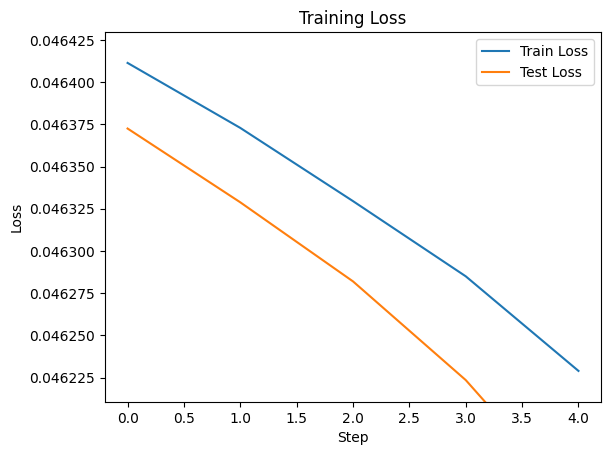

KeyboardInterrupt: 

In [15]:
batch_size = 16

for i in tqdm(range(10000)):
    indices, y_true = sample_batch(contents[:80], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)

    loss_train = transformer.train_step(indices, y_true)
    losses_train.append(loss_train)

    indices, y_true = sample_batch(contents[80:], 
                                   batch_size, 
                                   tokenizer, 
                                   max_seq_len)
    
    loss_test = transformer.evaluate(indices, y_true)
    losses_test.append(loss_test)

    
    clear_output(wait=True)
    x = np.arange(max(0, len(losses_train)-400), len(losses_train))
    plt.plot(x, losses_train[-400:], label="Train Loss")
    plt.plot(x, losses_test[-400:], label="Test Loss")

    Min = np.min(losses_train[-400:])
    Max = np.max(losses_train[-400:])
    delta = Max - Min
    plt.ylim(Min - delta*0.1, Max + delta*0.1)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

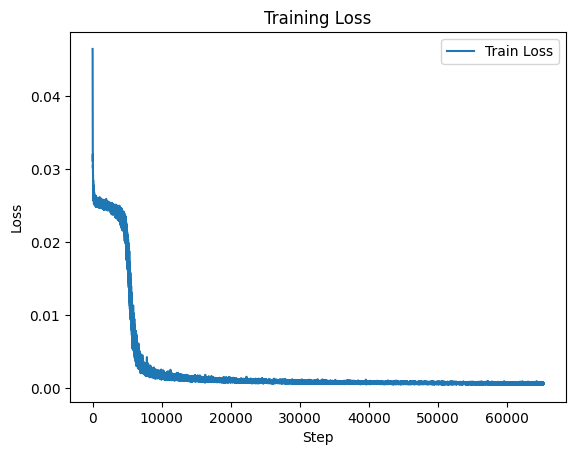

In [266]:

plt.plot(losses_train, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [268]:
idx = np.random.randint(100)
text = contents[idx]

print(text)

The Cold War aerial games of chicken portrayed in the movie "Top Gun" are happening in real life again nearly 30 years later.

A U.S. Air Force spy plane evaded an encounter with the Russian military on July 18, just a day after Malaysia Airlines Flight 17 was downed by a suspected surface-to-air missile that Ukraine and the West allege was fired by pro-Russia rebels in eastern Ukraine.

The RC-135 Rivet Joint fled into nearby Swedish airspace without that country's permission, a U.S. military official told CNN. The airplane may have gone through other countries' airspace as well, though it's not clear if it had permission to do so.

The U.S. plane had been flying in international airspace, conducting an electronic eavesdropping mission on the Russian military, when the Russians took the unusual action of beginning to track it with land-based radar.

The Russians then sent at least one fighter jet into the sky to intercept the aircraft, the U.S. official said Saturday.

The spy plane c

In [269]:
text = "The Cold War"
indices = tokenizer.tokenize([text])
print(indices)

tf.Tensor([[48 65 62  1 31 72 69 61  1 51 58 75]], shape=(1, 12), dtype=int32)


In [272]:
for i in range(128):
    y_pred = transformer.pred(indices)
    argmax = tf.cast(tf.argmax(y_pred[:, -2:-1], axis=-1), dtype=tf.int32)
    indices = tf.concat([indices, argmax], axis=1)
    text_pred = tokenizer.detokenize(indices)
    print(text_pred.numpy()[0].decode("utf-8"), end='\r', flush=True)
    time.sleep(0.05)


InvalidArgumentError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:AddV2]

In [263]:
import pickle

In [265]:
pickle.dump(transformer.parameter_list, open("transformer_weights.pkl", "wb"))
pickle.dump(tokenizer, open("tokenizer.pkl", "wb"))

InvalidArgumentError: Cannot convert a Tensor of dtype resource to a NumPy array.

## 